In [1]:
import pandas as pd
import numpy as np

import os
import sys
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from IPython.display import Audio
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
Tess = "E:\\tess\\TESS Toronto emotional speech set data\\TESS Toronto emotional speech set data\\"
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '\\' + file)
        
# dataframe for emotion 
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path 
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)
Ravdess_df.head()

['OAF_back_angry.wav', 'OAF_bar_angry.wav', 'OAF_base_angry.wav', 'OAF_bath_angry.wav', 'OAF_bean_angry.wav', 'OAF_beg_angry.wav', 'OAF_bite_angry.wav', 'OAF_boat_angry.wav', 'OAF_bone_angry.wav', 'OAF_book_angry.wav', 'OAF_bought_angry.wav', 'OAF_burn_angry.wav', 'OAF_cab_angry.wav', 'OAF_calm_angry.wav', 'OAF_came_angry.wav', 'OAF_cause_angry.wav', 'OAF_chain_angry.wav', 'OAF_chair_angry.wav', 'OAF_chalk_angry.wav', 'OAF_chat_angry.wav', 'OAF_check_angry.wav', 'OAF_cheek_angry.wav', 'OAF_chief_angry.wav', 'OAF_choice_angry.wav', 'OAF_cool_angry.wav', 'OAF_dab_angry.wav', 'OAF_date_angry.wav', 'OAF_dead_angry.wav', 'OAF_death_angry.wav', 'OAF_deep_angry.wav', 'OAF_dime_angry.wav', 'OAF_dip_angry.wav', 'OAF_ditch_angry.wav', 'OAF_dodge_angry.wav', 'OAF_dog_angry.wav', 'OAF_doll_angry.wav', 'OAF_door_angry.wav', 'OAF_fail_angry.wav', 'OAF_fall_angry.wav', 'OAF_far_angry.wav', 'OAF_fat_angry.wav', 'OAF_fit_angry.wav', 'OAF_five_angry.wav', 'OAF_food_angry.wav', 'OAF_gap_angry.wav', 'OAF_

,Emotions,Path
0,angry,E:\tess\TESS Toronto emotional speech set data...
1,angry,E:\tess\TESS Toronto emotional speech set data...
2,angry,E:\tess\TESS Toronto emotional speech set data...
3,angry,E:\tess\TESS Toronto emotional speech set data...
4,angry,E:\tess\TESS Toronto emotional speech set data...


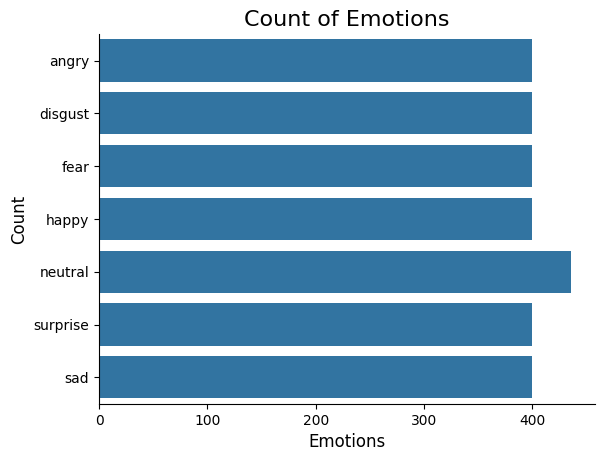

In [3]:
plt.title('Count of Emotions', size=16)
sns.countplot(Ravdess_df.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [4]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr, axis=0)
    plt.show()

def create_spectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    plt.colorbar()

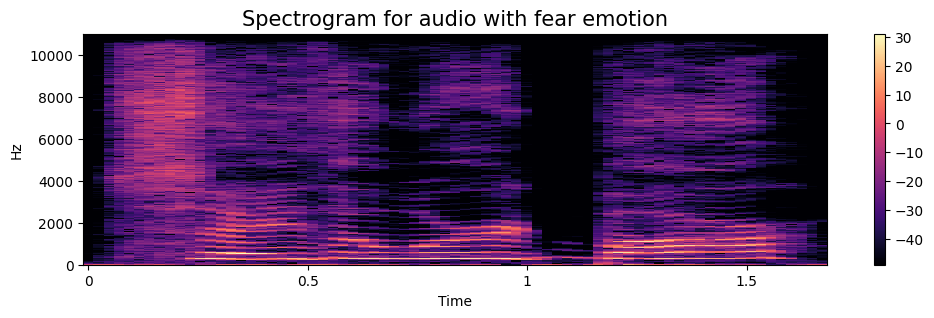

In [5]:
emotion='fear'
path = np.array(Ravdess_df.Path[Ravdess_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [6]:
def noise(y,noise_factor=0.15):
    noise = np.random.normal(0, noise_factor, size=y.shape)
    noisy_y = y + noise
    return noisy_y


In [7]:

path = np.array(Ravdess_df.Path)[1]
data, sample_rate = librosa.load(path)

In [8]:
def extract_features(data):
    result = np.array([])
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc))
    return result

In [9]:
def get_features(path):
    data, sample_rate = librosa.load(path, duration=2.5)
  
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2))
    
    return result

In [10]:
X, Y = [], []
for path, emotion in zip(Ravdess_df.Path, Ravdess_df.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

In [11]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,labels
0,-383.432617,52.460808,-17.608944,-11.810310,-4.707630,7.513892,-25.082636,-6.948460,-10.093306,-3.254936,...,0.656697,2.047498,2.982287,4.187005,1.354461,-3.593895,-2.941231,-3.203928,-8.714863,angry
1,20.408319,0.197013,-0.126078,-1.827721,-1.533023,-1.169320,-2.054855,-3.051615,-2.314648,-0.016402,...,1.317570,0.732448,0.516585,0.816090,0.618710,0.042213,-0.080777,-0.953523,-1.685755,angry
2,-444.550110,65.292038,-2.571654,-20.355955,-10.516433,10.241208,-9.607937,-1.355310,-12.456924,2.827871,...,9.995902,-0.791078,4.928980,1.611719,0.394611,-5.794950,-4.143381,-3.314804,-8.888524,angry
3,17.969732,-1.404071,0.879702,-0.222040,-0.209211,-0.134321,-0.873112,-1.184533,-1.366167,-0.583139,...,0.612155,1.052296,1.421310,1.133320,-0.666795,-0.894996,-0.982149,-1.518207,-0.993844,angry
4,-402.192657,26.256584,-5.023630,-0.407519,-0.952224,0.913046,-19.256067,-2.460230,-13.165890,-1.056540,...,7.668492,-0.763720,6.849833,-1.808660,-0.068707,-2.023833,-1.856652,-6.333825,-9.804387,angry


In [12]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [13]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [14]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4254, 20), (4254, 7), (1418, 20), (1418, 7))

In [15]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4254, 20), (4254, 7), (1418, 20), (1418, 7))

In [16]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4254, 20, 1), (4254, 7), (1418, 20, 1), (1418, 7))

In [17]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=7, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 20, 256)        │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 256)        │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 5, 128)         │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 3, 64)          │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 538,823 (2.06 MB)

 Trainable params: 538,823 (2.06 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.6, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.2436 - loss: 1.8221 - val_accuracy: 0.4718 - val_loss: 1.3231 - learning_rate: 0.0010
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.4858 - loss: 1.2888 - val_accuracy: 0.6354 - val_loss: 0.9585 - learning_rate: 0.0010
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.6183 - loss: 1.0296 - val_accuracy: 0.7073 - val_loss: 0.8307 - learning_rate: 0.0010
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.6624 - loss: 0.9204 - val_accuracy: 0.6883 - val_loss: 0.7781 - learning_rate: 0.0010
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.6899 - loss: 0.8274 - val_accuracy: 0.7334 - val_loss: 0.7252 - learning_rate: 0.0010
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.7383 - loss: 0.7433 - val_accuracy: 0.7525 - val_loss: 0.6587 - learning_rate: 0.0010
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.7461 - loss: 0.6836 - val_acc

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8297 - loss: 0.5262
Accuracy of our model on test data :  81.73483610153198 %


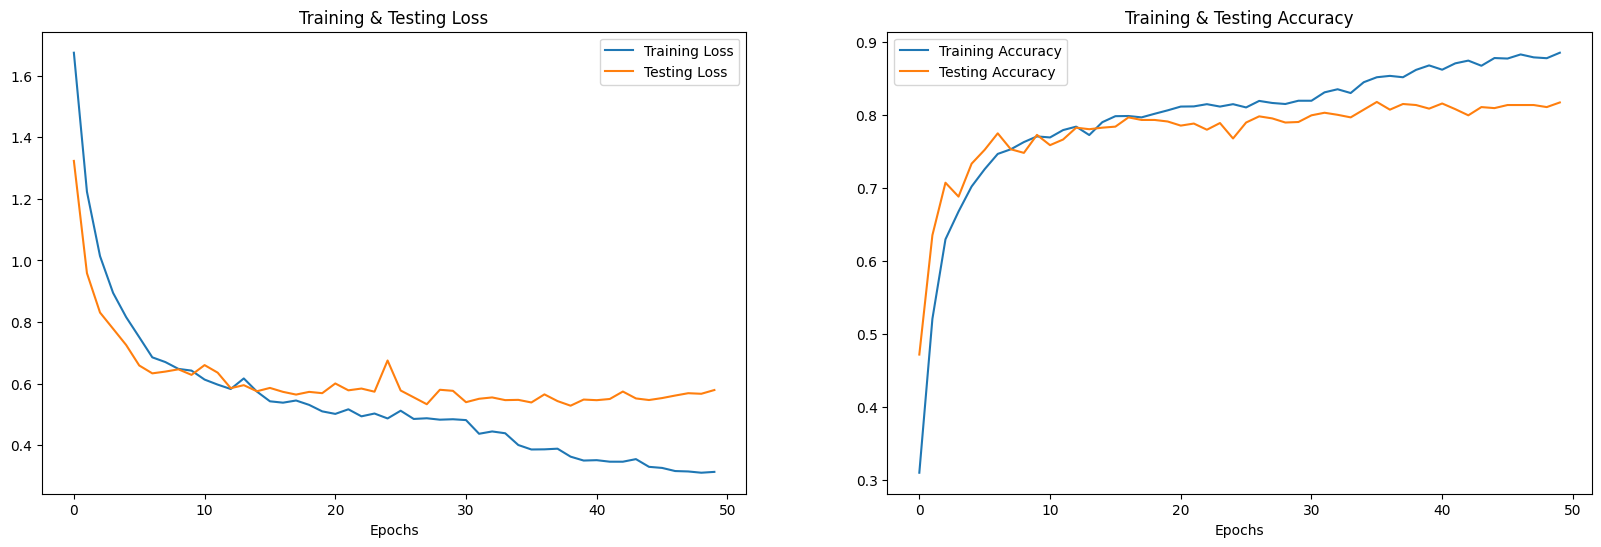

In [19]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [20]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


,Predicted Labels,Actual Labels
0,disgust,angry
1,neutral,sad
2,sad,sad
3,sad,sad
4,fear,fear
5,sad,sad
6,neutral,disgust
7,happy,happy
8,happy,happy
9,sad,fear


In [21]:
from tensorflow.keras.models import save_model
save_model(model, 'emotion_detection_model.h5')